In [1]:
from typing import List
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale
import cv2

# Generating Graphs From Gaussians
We create a plot of 4 gaussian clusters with 100 nodes each.

Text(0.5, 1.0, '4 Gaussian Clusters')

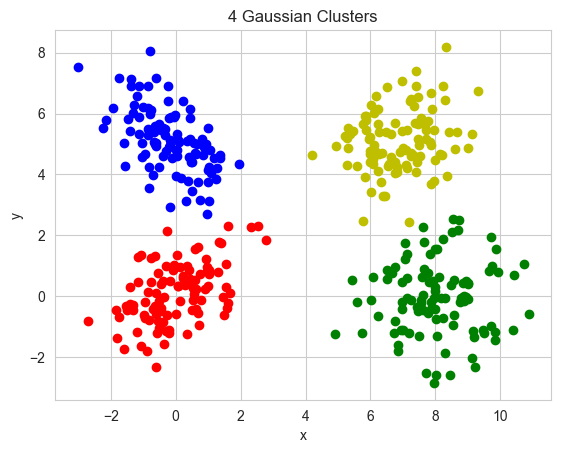

In [2]:
np.random.seed(9)
X1 = np.random.multivariate_normal(mean = [0,0], cov = [[1,0.5],[0.5,1]], size = 100)
X2 = np.random.multivariate_normal(mean = [0,5], cov = [[1,-0.5],[-0.5,1]], size = 100)
X3 = np.random.multivariate_normal(mean = [8,0], cov = [[1.5,0],[0,1]], size = 100)
X4 = np.random.multivariate_normal(mean = [7,5], cov = [[1,0.2],[0.2,1]], size = 100)
X = np.concatenate((X1, X2, X3, X4))
# plot with each cluster in a different color
plt.scatter(X1[:,0], X1[:,1], color = 'r')
plt.scatter(X2[:,0], X2[:,1], color = 'b')
plt.scatter(X3[:,0], X3[:,1], color = 'g')
plt.scatter(X4[:,0], X4[:,1], color = 'y')
plt.xlabel('x')
plt.ylabel('y')
plt.title('4 Gaussian Clusters')

Text(0.5, 1.0, 'Graph Constructed from 4 Gaussian Clusters \n Threshold = 4')

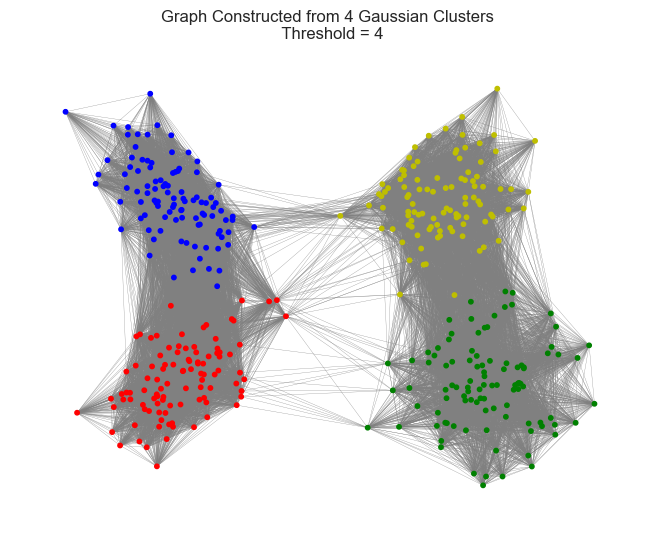

In [3]:
# construct a graph from the data points using a threshold
def construct_graph(X, threshold):
    N = X.shape[0]
    A = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                dist = np.linalg.norm(X[i] - X[j])
                if dist < threshold:
                    A[i, j] = 1
    return A

A = construct_graph(X, 4)
G = nx.from_numpy_array(A)
pos = X
# make edges thin and transparent. 
colormap = ['r'] * 100 + ['b'] * 100 + ['g'] * 100 + ['y'] * 100
nx.draw(G, pos = pos, node_size = 10, edge_color = 'grey', width = 0.2, node_color = colormap)
plt.title('Graph Constructed from 4 Gaussian Clusters \n Threshold = 4')

Text(0.5, 1.0, 'First 8 Eigenvalues of $\\mathcal{L}$')

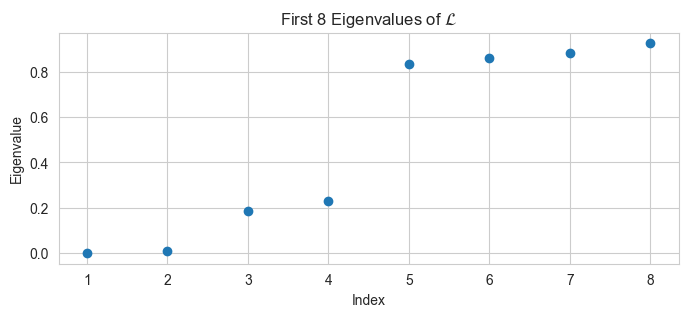

In [4]:
# compute the normalized laplacian

degrees = np.sum(A, axis = 1)
D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
norm_L = np.eye(A.shape[0]) - D_inv_sqrt @ A @ D_inv_sqrt
eigvals, eigvecs = np.linalg.eigh(norm_L)
idx = np.argsort(eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# plot first 10 eigenvalues
fig = plt.figure(figsize=(8, 3))
plt.scatter(range(1,9), eigvals[:8])
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title(r"First 8 Eigenvalues of $\mathcal{L}$")

# Clustering of AISTATS Text Image
In this section we construct a graph from the AISTATS text image and perform spectral clustering on the graph. We then compute and compare our bounds.

(-0.5, 77.5, 46.5, -0.5)

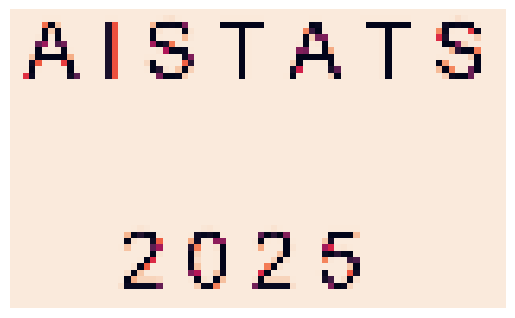

In [6]:
im = cv2.imread('Data/AISTATS2025-TEXT.png')
plt.imshow(im)
smoothed_im = gaussian_filter(im, sigma=1.0)
rescaled_smoothed_im = rescale(smoothed_im, 0.1, anti_aliasing=False)
plt.imshow(rescaled_smoothed_im)
# remove axes
plt.axis('off')

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(-0.5, 77.5, 46.5, -0.5)

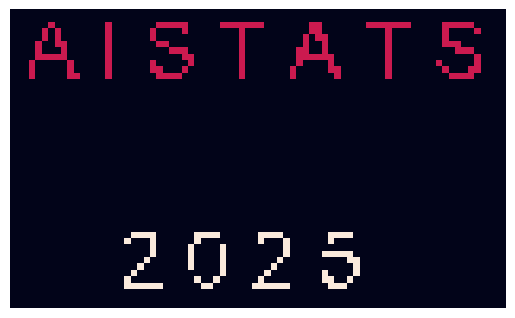

In [7]:
# Compute distance matrix
euc_distances_color = euclidean_distances(rescaled_smoothed_im.reshape(-1, 1))
euc_distances_color = euc_distances_color / euc_distances_color.max()
euc_distances_color_squared = euc_distances_color ** 2

euc_distances_distance = euclidean_distances(np.arange(rescaled_smoothed_im.size).reshape(-1, 1))
euc_distances_distance = euc_distances_distance / euc_distances_distance.max()
euc_distances_distance_squared = euc_distances_distance ** 2


def sigma_median(distances: np.ndarray) -> float:
    triu_distances = np.triu(distances, k=1)
    # choose not to include 0 distances in the calculation
    sigma = np.median(triu_distances[triu_distances > 0])
    return sigma


sigma_color = sigma_median(euc_distances_color)
sigma_distance = sigma_median(euc_distances_distance)
affinity_matrix = np.exp(-euc_distances_color_squared / (2 * sigma_color ** 2)) * np.exp(
    -euc_distances_distance_squared / (2 * sigma_distance ** 2))
# set diagonal to 0
np.fill_diagonal(affinity_matrix, 0)
# construct norm laplacian
degrees = np.sum(affinity_matrix, axis=1)
normalized_laplacian = np.eye(affinity_matrix.shape[0]) - np.diag(
    1 / np.sqrt(np.sum(affinity_matrix, axis=1))) @ affinity_matrix @ np.diag(
    1 / np.sqrt(np.sum(affinity_matrix, axis=1)))
eigenvalues, eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = eigenvalues.argsort()
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# apply spectral clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(eigenvectors[:, 0:3])

# Reshape the labels to the image shape
segmented_image = labels.reshape(rescaled_smoothed_im.shape)
plt.imshow(segmented_image)
plt.axis('off')

In [8]:
# Compute indicator vectors
indicator_vectors = np.zeros((eigenvectors.shape[0], n_clusters))
for i in range(n_clusters):
    indicator_vectors[:, i] = (labels == i).astype(int)

degrees = np.sum(affinity_matrix, axis=1)

D_sqrt = np.diag(np.sqrt(degrees))

for i in range(n_clusters):
    indicator_vectors[:, i] = D_sqrt @ indicator_vectors[:, i]
    indicator_vectors[:, i] = indicator_vectors[:, i]
    indicator_vectors[:, i] = indicator_vectors[:, i] / np.linalg.norm(indicator_vectors[:, i])

# project indicator vectors onto the eigenvectors
beta_K_by_K = (indicator_vectors.T @ eigenvectors[:,:n_clusters])


combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(n_clusters):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                    combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                         i]) * combined_indicator_vectors[:, j]
    
for i in range(n_clusters):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(combined_indicator_vectors[:, i])
    
# compute the rayleigh quotients
rayleigh_quotients = []
for i in range(n_clusters):
    indicator = combined_indicator_vectors[:, i]
    val = (indicator.T @ normalized_laplacian @ indicator) / (indicator.T @ indicator)
    rayleigh_quotients.append(val)

# sort the rayleigh quotients
sorted_rayleigh_quotients = np.sort(rayleigh_quotients)

In [9]:
B_1 = rayleigh_quotients[0]/eigenvalues[1]
B_2 = ((rayleigh_quotients[2] + rayleigh_quotients[1]) - 2*eigenvalues[1] + eigenvalues[3]*B_1)/(eigenvalues[3] - eigenvalues[1])

In [10]:
def compute_k_way_estimate(normalised_L, indicator_vectors, K):
    k_way_possibilities = []
    assert indicator_vectors.shape[1] == K, 'Indicator vectors should have K columns'
    for i in range(K):
        indicator = indicator_vectors[:, i]
        val = indicator.T @ normalised_L @ indicator
        k_way_possibilities.append(val)
    return max(k_way_possibilities)

In [11]:
print(f"Upper Bound from Recursive Structure Theorem: {B_1 + B_2}")
print(f"Lower Bound from General Structure Theorem: {np.sum(rayleigh_quotients)/eigenvalues[3]}")
print(f"Lower Bound from Structure Theorem: {3*compute_k_way_estimate(normalized_laplacian, indicator_vectors, 3)/eigenvalues[3]}")

Upper Bound from Recursive Structure Theorem: 0.5203243842695882
Lower Bound from General Structure Theorem: 0.7377032093746543
Lower Bound from Structure Theorem: 1.4194189108694533


# Plots for Synthetic Digraphs

In [12]:
def compute_volume(S: list, degrees: np.ndarray):
    return np.sum([degrees[i] for i in S])

#must use the adjacency matrix, not the hermitian adjacency matrix
def compute_weight_between_sets(S1:list, S2:list, A: np.ndarray):
    return np.sum([A[i,j] for i in S1 for j in S2])

def Upsilon(partition: List[List[int]], A: np.ndarray, degrees: np.ndarray, C: List[tuple]):
    k = len(partition)
    volume = np.sum(degrees)
    weight_total = 0
    for i in range(k):
        for j in range(k):
             if (i,j) not in C:
                 weight = compute_weight_between_sets(partition[i], partition[j], A)
                 weight_total += weight
    return weight_total/volume


def compute_theta(partition: List[List[int]], A: np.ndarray, degrees: np.ndarray, C: List[tuple]):
    k = len(partition)
    N = len(A)
    weight_total = 0
    for i in range(k):
        for j in range(k):
            if (i, j) in C:
                vol_i = compute_volume(partition[i], degrees)
                vol_j = compute_volume(partition[j], degrees)
                weight = compute_weight_between_sets(partition[i], partition[j], A) / (vol_i + vol_j)
                weight_total += weight
    return weight_total


def compute_new_bound(eigvals, ups):
    b1 = (4 * ups - eigvals[0]) / (eigvals[1] - eigvals[0])
    b2 = (4 * ups) / (eigvals[1])
    return np.min([b1, b2])


def compute_ls_bounds(eigvals, theta, k):
    gamma = eigvals[1] / (1 - (4 / k) * theta)
    bound_1 = 1 / gamma
    bound_2 = 1 / (gamma - 1)
    return bound_1, bound_2

In [13]:
def get_hermitian_adjacency_matrix(N, edges, root_of_unity: int = 4) -> np.array:
    adjacency_matrix = np.zeros((N, N), dtype=np.complex128)
    w_k = np.exp(2 * np.pi * 1j / root_of_unity)
    w_k_conj = np.conj(w_k)
    for edge in edges:
        adjacency_matrix[edge] = w_k
        adjacency_matrix[(edge[::-1])] = w_k_conj
    return adjacency_matrix

def get_adjacency_matrix(N, edges) -> np.array:
    adjacency_matrix = np.zeros((N, N))
    for edge in edges:
        adjacency_matrix[edge] = 1
    return adjacency_matrix

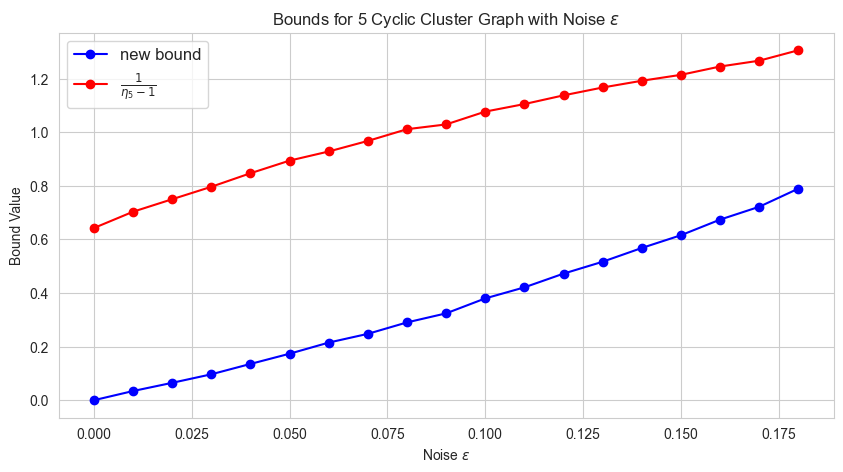

In [14]:
# construct directed graph with 10 cycle
n = [0, 100, 200, 300, 400, 500]
N = n[-1]
k = 5

bounds = {}

partition = []
for i in range(k):
    partition.append([j for j in range(n[i], n[i + 1])])
### FOR CYCLE
C = [(i, (i + 1) % k) for i in range(k)]
C_path = [(i, i + 1) for i in range(k - 1)]

F = np.array([[0.5, 1.0, 0.5, 0.5, 0.0],
              [0.0, 0.5, 1.0, 0.5, 0.5],
              [0.5, 0.0, 0.5, 1.0, 0.5],
              [0.5, 0.5, 0.0, 0.5, 1.0],
              [1.0, 0.5, 0.5, 0.0, 0.5]])

def generate_P_cycle(eps=0.01):
    P = [[eps, 1.0, eps, eps, 1.0],
         [1.0, eps, 1.0, eps, eps],
         [eps, 1.0, eps, 1.0, eps],
         [eps, eps, 1.0, eps, 1.0],
         [1.0, eps, eps, 1.0, eps]]
    return np.array(P)


for eps in np.arange(0, 0.2, 0.01):
    P = generate_P_cycle(eps)
    edges = []

    for i in range(k):
        for j in range(k):
            if i == j:
                prob_existing_edge = P[i, j]
                for index, u in enumerate(partition[i]):
                    for v in partition[i][index + 1:]:
                        if u == v:
                            continue
                        if np.random.rand() <= prob_existing_edge:
                            if np.random.rand() <= F[i, j]:
                                edges.append((u, v))
                            else:
                                edges.append((v, u))
            else:
                prob_existing_edge = P[i, j]
                for u in partition[i]:
                    for v in partition[j]:
                        if np.random.rand() <= prob_existing_edge:
                            if np.random.rand() <= F[i, j]:
                                edges.append((u, v))
                            else:
                                edges.append((v, u))


    A = get_hermitian_adjacency_matrix(N = N, edges = edges, root_of_unity=k)
    degrees = np.sum(np.abs(A), axis=1)
    D = np.diag(degrees)
    D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
    norm_L = np.eye(int(N)) - D_inv_sqrt @ A @ D_inv_sqrt

    #Now computing using Laenen & Sun's choice of roots of unity
    k_ls = int(np.ceil(2 * np.pi * k))
    A_ls = get_hermitian_adjacency_matrix(N = N, edges = edges, root_of_unity=k_ls)
    D_ls = np.sum(np.abs(A_ls), axis=1)
    D_inv_sqrt_ls = np.diag(1 / np.sqrt(D_ls))
    norm_L_ls = np.eye(int(N)) - D_inv_sqrt_ls @ A_ls @ D_inv_sqrt_ls

    eigvals, eigvecs = np.linalg.eigh(norm_L)
    idx = eigvals.argsort()
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    ls_eigvals, ls_eigvecs = np.linalg.eigh(norm_L_ls)
    # sort
    idx = ls_eigvals.argsort()
    ls_eigvals = ls_eigvals[idx]
    ls_eigvecs = ls_eigvecs[:, idx]
    A_standard = get_adjacency_matrix(N, edges)
    ups = Upsilon(partition, A_standard, degrees, C)
    theta = compute_theta(partition, A_standard, degrees, C_path)
    new_bound = compute_new_bound(eigvals, ups)
    ls_bound_1, ls_bound_2 = compute_ls_bounds(ls_eigvals, theta, k)

    bounds[eps] = {'new_bound': new_bound, 'ls_bound_1': ls_bound_1, 'ls_bound_2': ls_bound_2}
bounds_df = pd.DataFrame(bounds).T
bounds_df.columns = ['new bound', r'$\frac{1}{\eta_k}$',
                     r'$\frac{1}{\eta_5-1}$']
bounds_df[['new bound', r'$\frac{1}{\eta_5-1}$']][
    (bounds_df['new bound'] <= 0.8) + (bounds_df[r'$\frac{1}{\eta_5-1}$'] <= 0.8)].plot(
    title=r'Bounds for 5 Cyclic Cluster Graph with Noise $\epsilon$', marker='o', linestyle='-', color=['blue', 'red'],
    figsize=(10, 5))
plt.xlabel(r'Noise $\epsilon$')
plt.ylabel(r'Bound Value')
plt.grid(True)

plt.legend(fontsize='large')
plt.savefig('5_cluster_cycle_noise.png')

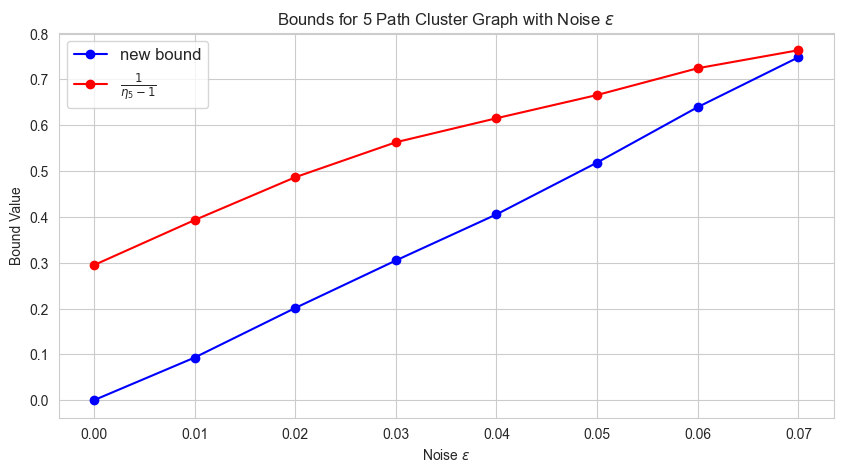

In [15]:
def generate_P_path(eps= 0.01):
     P = [[eps,1.0,eps,eps,eps],
          [1.0,eps,1.0,eps,eps],
          [eps,1.0,eps,1.0,eps],
          [eps,eps,1.0,eps,1.0],
          [eps,eps,eps,1.0,eps]]
     return np.array(P)

F = np.array([[0.5, 1.0, 0.5, 0.5, 0.5],
              [0.0, 0.5, 1.0, 0.5, 0.5],
              [0.5, 0.0, 0.5, 1.0, 0.5],
              [0.5, 0.5, 0.0, 0.5, 1.0],
              [0.5, 0.5, 0.5, 0.0, 0.5]])

for eps in np.arange(0, 0.2, 0.01):
    P = generate_P_path(eps)

    

    edges = []

    for i in range(k):
        for j in range(k):
            if i == j:
                prob_existing_edge = P[i, j]
                for index, u in enumerate(partition[i]):
                    for v in partition[i][index + 1:]:
                        if u == v:
                            continue
                        if np.random.rand() <= prob_existing_edge:
                            if np.random.rand() <= F[i, j]:
                                edges.append((u, v))
                            else:
                                edges.append((v, u))
            else:
                prob_existing_edge = P[i, j]
                for u in partition[i]:
                    for v in partition[j]:
                        if np.random.rand() <= prob_existing_edge:
                            if np.random.rand() <= F[i, j]:
                                edges.append((u, v))
                            else:
                                edges.append((v, u))


    A = get_hermitian_adjacency_matrix(N = N, edges = edges, root_of_unity=k)
    degrees = np.sum(np.abs(A), axis=1)
    D = np.diag(degrees)
    D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
    norm_L = np.eye(int(N)) - D_inv_sqrt @ A @ D_inv_sqrt

    #Now computing using Laenen & Sun's choice of roots of unity
    k_ls = int(np.ceil(2 * np.pi * k))
    A_ls = get_hermitian_adjacency_matrix(N = N, edges = edges, root_of_unity=k_ls)
    D_ls = np.sum(np.abs(A_ls), axis=1)
    D_inv_sqrt_ls = np.diag(1 / np.sqrt(D_ls))
    norm_L_ls = np.eye(int(N)) - D_inv_sqrt_ls @ A_ls @ D_inv_sqrt_ls

    eigvals, eigvecs = np.linalg.eigh(norm_L)
    idx = eigvals.argsort()
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    ls_eigvals, ls_eigvecs = np.linalg.eigh(norm_L_ls)
    # sort
    idx = ls_eigvals.argsort()
    ls_eigvals = ls_eigvals[idx]
    ls_eigvecs = ls_eigvecs[:, idx]
    A_standard = get_adjacency_matrix(N, edges)
    ups = Upsilon(partition, A_standard, degrees, C)
    theta = compute_theta(partition, A_standard, degrees, C_path)
    new_bound = compute_new_bound(eigvals, ups)
    ls_bound_1, ls_bound_2 = compute_ls_bounds(ls_eigvals, theta, k)

    bounds[eps] = {'new_bound': new_bound, 'ls_bound_1': ls_bound_1, 'ls_bound_2': ls_bound_2}
bounds_df = pd.DataFrame(bounds).T
bounds_df.columns = ['new bound', r'$\frac{1}{\eta_k}$',
                     r'$\frac{1}{\eta_5-1}$']
bounds_df[['new bound', r'$\frac{1}{\eta_5-1}$']][
    (bounds_df['new bound'] <= 0.8) + (bounds_df[r'$\frac{1}{\eta_5-1}$'] <= 0.8)].plot(
    title=r'Bounds for 5 Path Cluster Graph with Noise $\epsilon$', marker='o', linestyle='-', color=['blue', 'red'],
    figsize=(10, 5))
plt.xlabel(r'Noise $\epsilon$')
plt.ylabel(r'Bound Value')
plt.grid(True)

plt.legend(fontsize='large')
plt.savefig('5_cluster_path_noise.png')

# YellowStone Graph

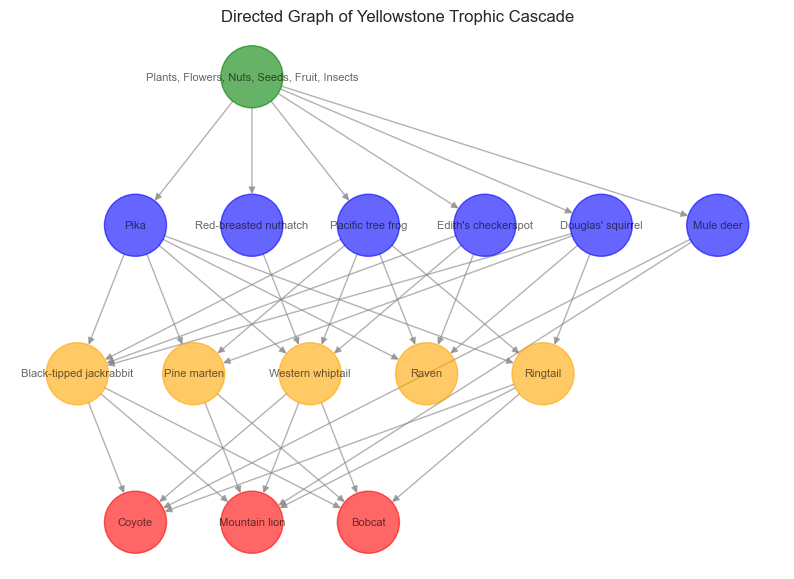

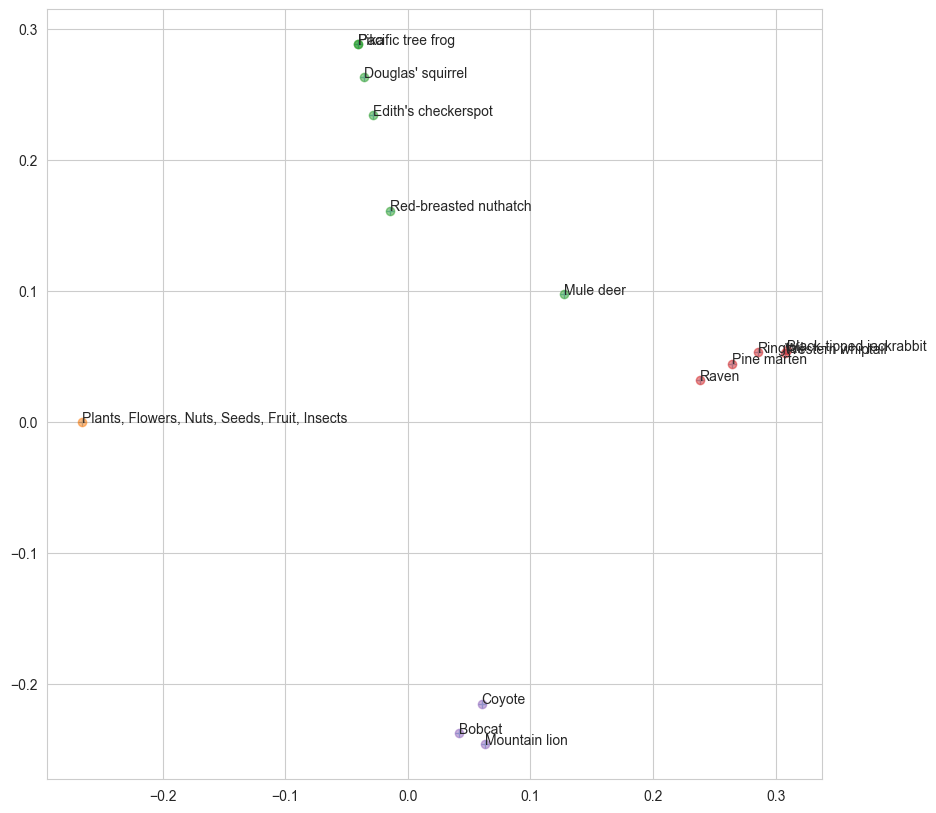

In [16]:
# Nodes and edges for the second image
nodes = [
    "Plants, Flowers, Nuts, Seeds, Fruit, Insects", "Pika", "Red-breasted nuthatch",
    "Pacific tree frog", "Edith's checkerspot", "Douglas' squirrel", "Mule deer",
    "Black-tipped jackrabbit", "Pine marten", "Western whiptail", "Raven",
    "Ringtail", "Coyote", "Mountain lion", "Bobcat"
]

# Initialize the adjacency matrix with zeros
adj_matrix = np.zeros((len(nodes), len(nodes)), dtype=int)

# Map the nodes to matrix index
index_map = {species: i for i, species in enumerate(nodes)}

partition = {"Producers and Decomposer": ["Plants, Flowers, Nuts, Seeds, Fruit, Insects"],
             "Primary Consumers": ["Pika", "Red-breasted nuthatch", "Pacific tree frog", "Edith's checkerspot",
                                   "Douglas' squirrel", "Mule deer"],
             "Secondary Consumers": ["Black-tipped jackrabbit", "Pine marten", "Western whiptail", "Raven", "Ringtail"],
             "Tertiary Consumers": ["Coyote", "Mountain lion", "Bobcat"]}

partition_numbered = [[index_map[species] for species in community] for community in partition.values()]
# Manually add edges based on the image (directed edges where energy is transferred)
edges = [
    ("Plants, Flowers, Nuts, Seeds, Fruit, Insects", "Pika"),
    ("Plants, Flowers, Nuts, Seeds, Fruit, Insects", "Red-breasted nuthatch"),
    ("Plants, Flowers, Nuts, Seeds, Fruit, Insects", "Pacific tree frog"),
    ("Plants, Flowers, Nuts, Seeds, Fruit, Insects", "Edith's checkerspot"),
    ("Plants, Flowers, Nuts, Seeds, Fruit, Insects", "Douglas' squirrel"),
    ("Plants, Flowers, Nuts, Seeds, Fruit, Insects", "Mule deer"),

    ("Pika", "Ringtail"),
    ("Pika", "Western whiptail"),
    ("Pika", "Raven"),
    ("Pika", "Black-tipped jackrabbit"),
    ("Pika", "Pine marten"),

    ("Red-breasted nuthatch", "Western whiptail"),

    ("Pacific tree frog", "Ringtail"),
    ("Pacific tree frog", "Western whiptail"),
    ("Pacific tree frog", "Raven"),
    ("Pacific tree frog", "Black-tipped jackrabbit"),
    ("Pacific tree frog", "Pine marten"),

    ("Edith's checkerspot", "Western whiptail"),
    ("Edith's checkerspot", "Raven"),
    ("Edith's checkerspot", "Black-tipped jackrabbit"),

    ("Douglas' squirrel", "Ringtail"),
    ("Douglas' squirrel", "Raven"),
    ("Douglas' squirrel", "Black-tipped jackrabbit"),
    ("Douglas' squirrel", "Pine marten"),

    ("Mule deer", "Mountain lion"),
    ("Mule deer", "Coyote"),

    ("Ringtail", "Coyote"),
    ("Ringtail", "Mountain lion"),
    ("Ringtail", "Bobcat"),

    ("Western whiptail", "Mountain lion"),
    ("Western whiptail", "Bobcat"),
    ("Western whiptail", "Coyote"),

    ("Black-tipped jackrabbit", "Mountain lion"),
    ("Black-tipped jackrabbit", "Coyote"),
    ("Black-tipped jackrabbit", "Bobcat"),

    ("Pine marten", "Mountain lion"),
    ("Pine marten", "Bobcat")
]

# Now we can fill the adjacency matrix again based on these edges
for source, target in edges:
    adj_matrix[index_map[source], index_map[target]] = 1

# Create a DataFrame for better visualization
adj_matrix_df = pd.DataFrame(adj_matrix, index=nodes, columns=nodes)
G = nx.DiGraph()

# Add edges to the graph from the previous trophic relationships
G.add_edges_from(edges)

pos = {
    "Plants, Flowers, Nuts, Seeds, Fruit, Insects": (0, 3),
    "Pika": (-1, 2), "Red-breasted nuthatch": (0, 2), "Pacific tree frog": (1, 2), "Edith's checkerspot": (2, 2),
    "Douglas' squirrel": (3, 2), "Mule deer": (4, 2),
    "Black-tipped jackrabbit": (-1.5, 1), "Pine marten": (-0.5, 1), "Western whiptail": (0.5, 1), "Raven": (1.5, 1),
    "Ringtail": (2.5, 1),
    "Coyote": (-1, 0), "Mountain lion": (0, 0), "Bobcat": (1, 0)
}

# Color mapping for different communities
color_map = {
    "Producers and Decomposer": "green",
    "Primary Consumers": "blue",
    "Secondary Consumers": "orange",
    "Tertiary Consumers": "red"
}

# Assign colors based on community
node_colors = []
for node in G.nodes():
    for community, members in partition.items():
        if node in members:
            node_colors.append(color_map[community])

# Plot the graph using networkx
plt.figure(figsize=(10, 7))
nx.draw_networkx(G, pos, with_labels=True, node_size=2000, node_color=node_colors,
                 font_size=8, font_color='black', edge_color='gray', arrows=True, alpha=0.6)

# Display the plot
plt.title('Directed Graph of Yellowstone Trophic Cascade')
plt.axis('off')
plt.show()

# compute hermitian adjacency matrix
k = 4
k_ls = int(np.ceil(2 * np.pi * k))
A = adj_matrix * np.exp(1j * 2 * np.pi / 4) + adj_matrix.T * np.exp(-1j * 2 * np.pi / 4)
A_ls = adj_matrix * np.exp(1j * 2 * np.pi / k_ls) + adj_matrix.T * np.exp(-1j * 2 * np.pi / k_ls)
# compute degree matrix
degrees = np.sum(np.abs(A), axis=1)
D = np.diag(degrees)
D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
norm_L = np.eye(len(nodes)) - D_inv_sqrt @ A @ D_inv_sqrt

#Now computing using Laenen & Sun's choice of roots of unity
D_ls = np.sum(np.abs(A_ls), axis=1)
D_inv_sqrt_ls = np.diag(1 / np.sqrt(D_ls))
norm_L_ls = np.eye(len(nodes)) - D_inv_sqrt_ls @ A_ls @ D_inv_sqrt_ls
evals, evecs = np.linalg.eigh(norm_L)
evals_ls, evecs_ls = np.linalg.eigh(norm_L_ls)
# plot first evec
plt.figure(figsize=(10, 10))
i = 1
plt.plot(evecs[:, 0].real, evecs[:, 0].imag, '+', label='standard', alpha=0.5)
# add labels
for i, txt in enumerate(nodes):
    plt.annotate(txt, (evecs[i, 0].real, evecs[i, 0].imag))

# colour by community
for i, community in enumerate(partition_numbered):
    plt.plot(evecs[community, 0].real, evecs[community, 0].imag, 'o', label=f'community {i}', alpha=0.5)
C = [(0, 1), (1, 2), (2, 3), (3, 0)]



In [17]:
theta = compute_theta(partition_numbered, adj_matrix, degrees, [(i, i + 1) for i in range(4)])
ls_1, ls_2 = compute_ls_bounds(evals_ls, theta, k)
print("Theta is ", theta)
print("1/eta_k is ", ls_1)
print("1/(eta_k-1) is ", ls_2)

Theta is  0.7766774891774892
1/eta_k is  0.39849504527744173
1/(eta_k-1) is  0.6624966962429194


In [18]:
upsilon = Upsilon(partition_numbered, adj_matrix, degrees, C)
new_bound = compute_new_bound(evals, upsilon)
print("Upsilon is ", upsilon)
print("New bound is ",new_bound)

Upsilon is  0.02702702702702703
New bound is  0.20554458932200087


# Covid Infection Graph

In [19]:
patient_info_df = pd.read_csv("Data/PatientInfo.csv")
patient_info_df.head()
edges_df = patient_info_df[["infected_by", "patient_id"]].dropna(subset=["infected_by"])
edges_df.columns = ["source", "target"]
edges_df = edges_df.astype(str)
# create adjacency matrix
index = list(set(edges_df["source"].values) | set(edges_df["target"].values))
index.sort()
adjacency_matrix = np.zeros((len(index), len(index)))
for i, row in edges_df.iterrows():
    source = row["source"]
    target = row["target"]
    source_index = index.index(source)
    target_index = index.index(target)
    adjacency_matrix[source_index, target_index] = 1
adjacency_matrix_df = pd.DataFrame(adjacency_matrix, index=index, columns=index)


C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Theta 0.707896415359102
1/eta_k 0.2634522414117878
Upsilon 0.0
New bound -2.0888718762080712e-14


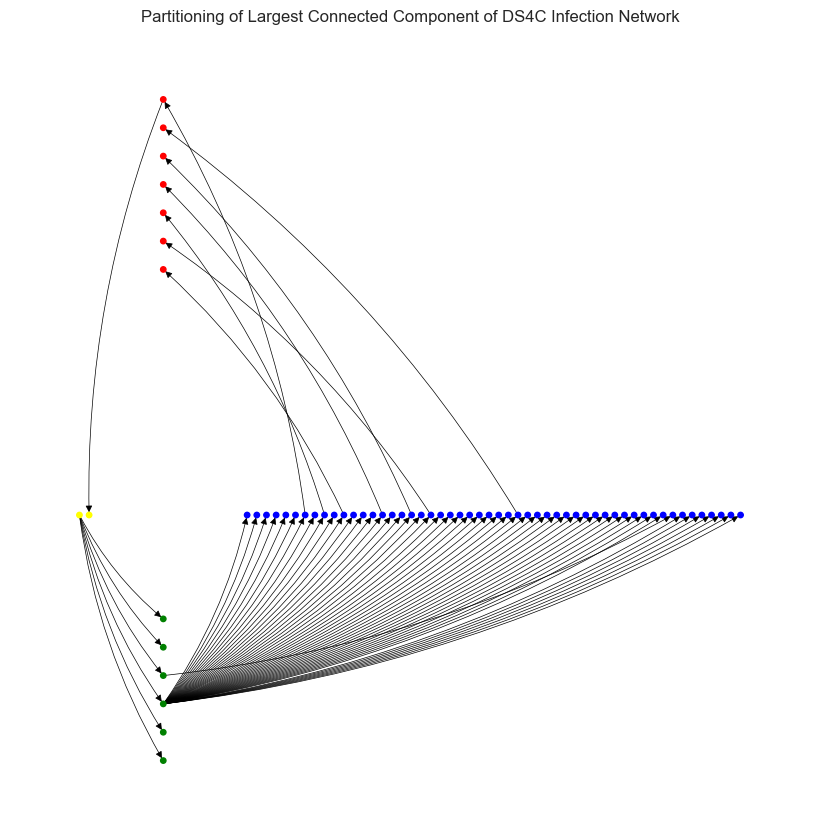

In [20]:

def largest_connected_component_adjacency(df):
    # Convert the DataFrame to a NumPy array
    adj_matrix = df

    # Create a directed graph from the adjacency matrix
    G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

    # Find the largest strongly connected component
    largest_wcc = max(nx.weakly_connected_components(G), key=len)

    # Create a subgraph from the largest SCC
    largest_wcc_subgraph = G.subgraph(largest_wcc)

    # Get the adjacency matrix of the largest SCC subgraph
    largest_wcc_adj_matrix = nx.to_numpy_array(largest_wcc_subgraph, nodelist=sorted(largest_wcc))

    # Create a new DataFrame for the adjacency matrix of the largest SCC
    largest_wcc_df = pd.DataFrame(largest_wcc_adj_matrix,
                                  index=sorted(largest_wcc),
                                  columns=sorted(largest_wcc))

    return largest_wcc_df

largest_wcc_df = largest_connected_component_adjacency(adjacency_matrix_df)
# draw graph
G = nx.from_pandas_adjacency(largest_wcc_df, create_using=nx.DiGraph)

k = 4
herm_A = np.exp(1j * 2 * np.pi / k) * largest_wcc_df.values + np.exp(-1j * 2 * np.pi / k) * largest_wcc_df.values.T
degrees = np.sum(np.abs(herm_A), axis=1)
D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
norm_L = np.eye(len(herm_A)) - D_inv_sqrt @ herm_A @ D_inv_sqrt

k_ls = int(np.ceil(2 * np.pi * k))
herm_A_ls = np.exp(1j * 2 * np.pi / k_ls) * largest_wcc_df.values + np.exp(
    -1j * 2 * np.pi / k_ls) * largest_wcc_df.values.T
degrees_ls = np.sum(np.abs(herm_A_ls), axis=1)
D_inv_sqrt_ls = np.diag(1 / np.sqrt(degrees_ls))
norm_L_ls = np.eye(len(herm_A_ls)) - D_inv_sqrt_ls @ herm_A_ls @ D_inv_sqrt_ls

# Compute Eigenvectors and Eigenvalues
e_vals, e_vecs = np.linalg.eigh(norm_L)
e_vals_ls, e_vecs_ls = np.linalg.eigh(norm_L_ls)


datapoints = np.column_stack((D_inv_sqrt @ e_vecs[:, 0].real, D_inv_sqrt @ e_vecs[:, 0].imag))
kmeans = KMeans(n_clusters=4, random_state=0).fit(datapoints)
partition_numbered = [np.where(kmeans.labels_ == i)[0] for i in range(4)]

color_map = []
for i, node in enumerate(largest_wcc_df.index):
    if i in partition_numbered[0]:
        color_map.append('blue')
    elif i in partition_numbered[1]:
        color_map.append('red')
    elif i in partition_numbered[2]:
        color_map.append('green')
    elif i in partition_numbered[3]:
        color_map.append('yellow')
    else:
        color_map.append('black')
G = nx.from_pandas_adjacency(largest_wcc_df, create_using=nx.DiGraph)
pos = {}
partition_sizes = [len(partition) for partition in partition_numbered]
scale = 60
for i, node_number in enumerate(largest_wcc_df.index):
    if i in partition_numbered[0]:
        index_in_partition = np.where(partition_numbered[0] == i)[0][0]
        pos[node_number] = (10 + scale * index_in_partition / partition_sizes[0], 0)
    elif i in partition_numbered[1]:
        index_in_partition = np.where(partition_numbered[1] == i)[0][0]
        pos[node_number] = (0, 10 + scale * index_in_partition / partition_sizes[0])
    elif i in partition_numbered[2]:
        index_in_partition = np.where(partition_numbered[2] == i)[0][0]
        pos[node_number] = (0, -10 + scale * index_in_partition / partition_sizes[0])
    elif i in partition_numbered[3]:
        index_in_partition = np.where(partition_numbered[3] == i)[0][0]
        pos[node_number] = (-10 + scale * index_in_partition / partition_sizes[0], 0)
    else:
        pos[node_number] = (0, 0)

plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color=color_map, with_labels=False, node_size=15, width=0.5, connectionstyle='arc3, rad = 0.1')
plt.title("Partitioning of Largest Connected Component of DS4C Infection Network")
# compute weight between every pair of clusters

C = [(2, 0), (0, 1), (1, 3), (3, 2)]

theta = compute_theta(partition_numbered, largest_wcc_df.values, degrees, C)
compute_ls_bounds(e_vals_ls, theta, k)
e_vals_ls[1] / (1 - (4 / k) * theta)
print("Theta", theta)
print("1/eta_k", e_vals_ls[1] / (1 - (4 / k) * theta))

print("Upsilon", Upsilon(partition_numbered, largest_wcc_df.values, degrees, C))
print("New bound", compute_new_bound(e_vals, Upsilon(partition_numbered, largest_wcc_df.values, degrees, C)))


# C elegans Graph

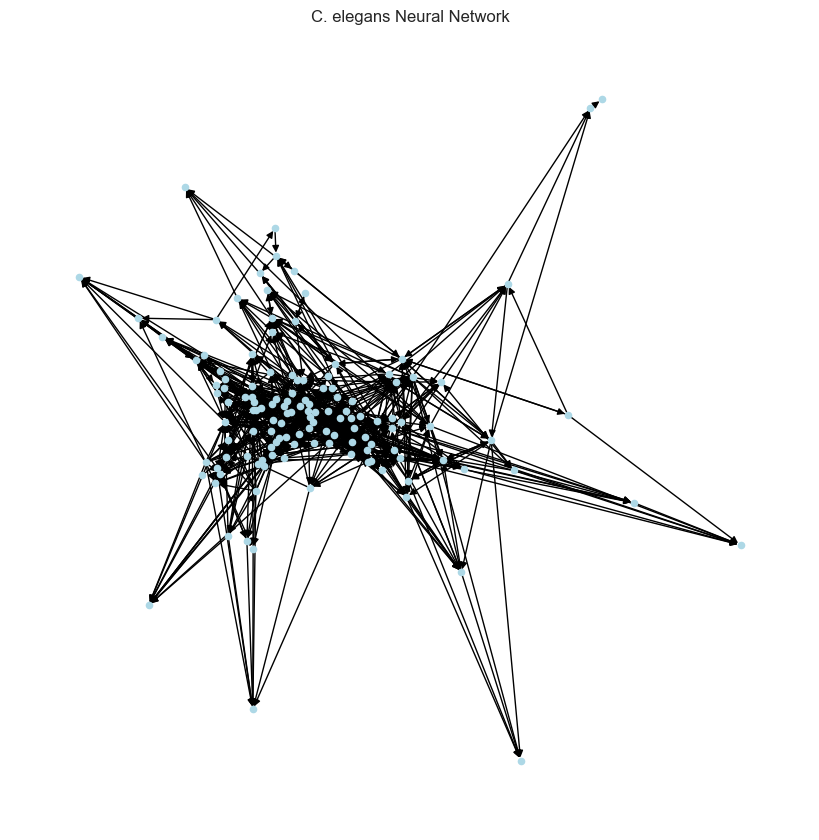

In [22]:
# import the C.elegans neural network
# Load the graph from the local file
c_elegans_graph = nx.read_edgelist("Data/C-elegans-frontal.txt", comments='#', nodetype=int, create_using=nx.DiGraph)

# Draw the graph (optional, can be time-consuming for large networks)
plt.figure(figsize=(8, 8))
nx.draw(c_elegans_graph, node_size=20, node_color='lightblue')
plt.title("C. elegans Neural Network")
plt.show()


In [23]:
# compute the adjacency matrix
adj_matrix = nx.to_numpy_array(c_elegans_graph, nodelist=sorted(c_elegans_graph.nodes()))
# compute hermitian adjacency matrix
k = 2
k_ls = int(np.ceil(2 * np.pi * k))
herm_A = np.exp(1j * 2 * np.pi / k) * adj_matrix + np.exp(-1j * 2 * np.pi / k) * adj_matrix.T
degrees = np.sum(np.abs(herm_A), axis=1)
D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
norm_L = np.eye(len(adj_matrix)) - D_inv_sqrt @ herm_A @ D_inv_sqrt

eigvals, eigvecs = np.linalg.eigh(norm_L)
idx = eigvals.argsort()
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]



In [24]:
norm_L

array([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 1.+0.j]])

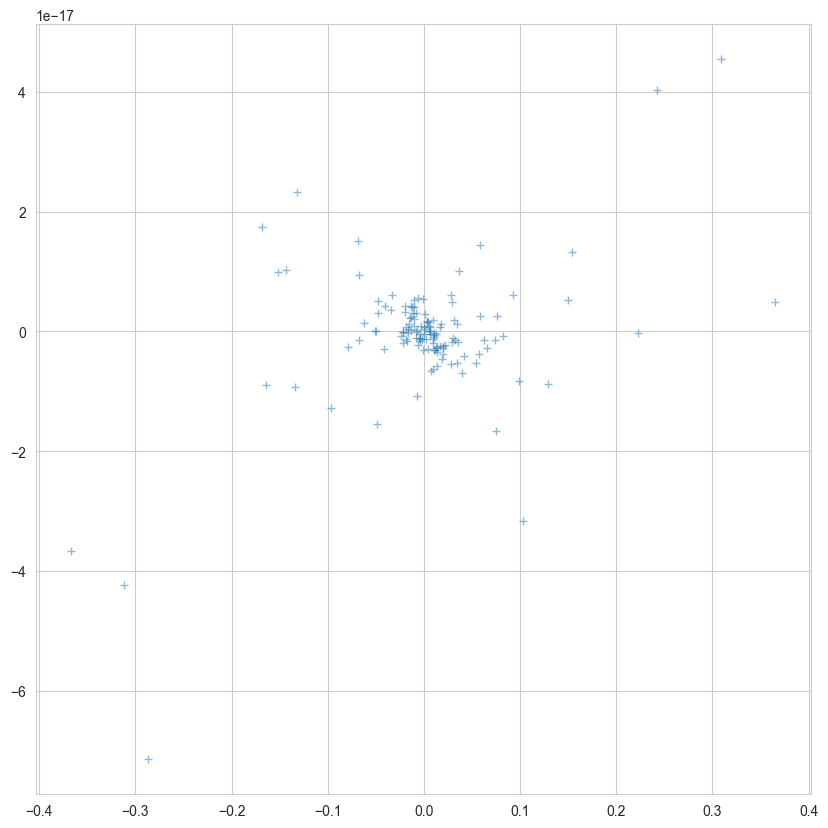

In [25]:
# plot first eigenvector
plt.figure(figsize=(10, 10))
plt.plot(eigvecs[:, 1].real, eigvecs[:, 1].imag, '+', label='standard', alpha=0.5) #np.zeros(len(eigvecs[:,0],))

(-0.1, 0.1)

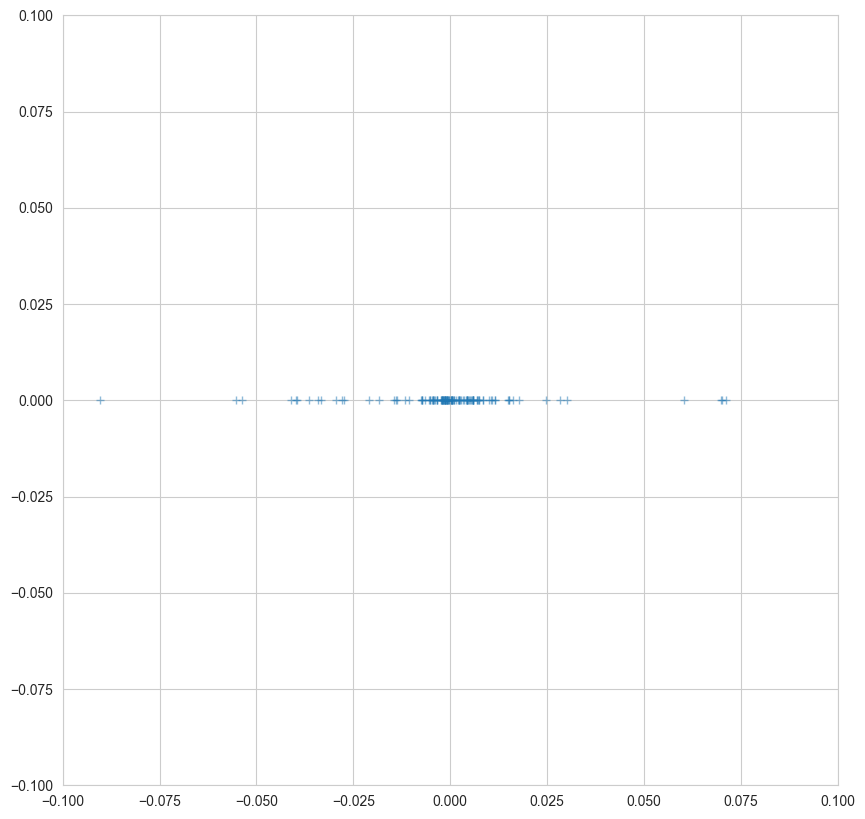

In [26]:
# zoom in on center of plot
plt.figure(figsize=(10, 10))
plt.plot(eigvecs[:, 0].real, eigvecs[:, 0].imag, '+', label='standard', alpha=0.5)
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)

In [ ]:
# cluster using first eigenvector
datapoints = np.column_stack((D_inv_sqrt @ eigvecs[:, 0].real, D_inv_sqrt @ eigvecs[:, 0].imag))
kmeans = KMeans(n_clusters=k, random_state=0).fit(datapoints)
partition_numbered = [np.where(kmeans.labels_ == i)[0] for i in range(k)]

# construct indicator vector of clusters
ind_vector = np.zeros((len(adj_matrix),), dtype = np.complex128)
for i, cluster in enumerate(partition_numbered):
    ind_vector[cluster] = np.exp(2 * np.pi * 1j * i / k)
    
ind_vector = D_sqrt @ ind_vector
ind_vector = ind_vector / np.linalg.norm(ind_vector)

# rotate indicator vector to align with first eigenvector
alpha = np.conj(ind_vector).T @ eigvecs[:, 0]
ind_vector = alpha * ind_vector
ind_vector = ind_vector / np.linalg.norm(ind_vector)

# Florida Bay Graph

In [ ]:
florida_bay_graph = nx.read_edgelist("Data/Florida-bay.txt", comments='#', nodetype=int, create_using=nx.DiGraph)

# Draw the graph (optional, can be time-consuming for large networks)
plt.figure(figsize=(8, 8))
nx.draw(florida_bay_graph, node_size=20, node_color='lightblue')
plt.title("Florida Bay Network")
plt.show()

In [ ]:
# compute the adjacency matrix
adj_matrix = nx.to_numpy_array(florida_bay_graph, nodelist=sorted(florida_bay_graph.nodes()))
# compute hermitian adjacency matrix
k = 4
k_ls = int(np.ceil(2 * np.pi * k))
herm_A = np.exp(1j * 2 * np.pi / k) * adj_matrix + np.exp(-1j * 2 * np.pi / k) * adj_matrix.T
degrees = np.sum(np.abs(herm_A), axis=1)
D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
D_sqrt = np.diag(np.sqrt(degrees))
norm_L = np.eye(len(adj_matrix)) - D_inv_sqrt @ herm_A @ D_inv_sqrt

eigvals, eigvecs = np.linalg.eigh(norm_L)
idx = eigvals.argsort()
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# cluster using first eigenvector
datapoints = np.column_stack((D_inv_sqrt @ eigvecs[:, 0].real, D_inv_sqrt @ eigvecs[:, 0].imag))
kmeans = KMeans(n_clusters=k, random_state=0).fit(datapoints)
#ordering = [2,0,4,1,3]
partition_numbered = [np.where(kmeans.labels_ == i)[0] for i in range(k)]


# construct indicator vector of clusters
ind_vector = np.zeros((len(adj_matrix),), dtype = np.complex128)

for i, cluster in enumerate(partition_numbered):
    ind_vector[cluster] = np.exp(2 * np.pi * 1j * i/ k)
    
ind_vector = D_sqrt @ ind_vector
ind_vector = ind_vector / np.linalg.norm(ind_vector)

# rotate indicator vector to align with first eigenvector
alpha = np.conj(ind_vector).T @ eigvecs[:, 0]
ind_vector = alpha * ind_vector
ind_vector = ind_vector / np.linalg.norm(ind_vector)

In [ ]:
eigvals[0], eigvals[1]

In [ ]:
import itertools
rayleigh_quotients_all = []
for perm in itertools.permutations(range(5)):    
    # construct indicator vector of clusters
    ind_vector = np.zeros((len(adj_matrix),), dtype = np.complex128)
    
    for i, cluster in enumerate(partition_numbered):
        ind_vector[cluster] = np.exp(2 * np.pi * 1j * perm[i] / k)
        
    ind_vector = D_sqrt @ ind_vector
    ind_vector = ind_vector / np.linalg.norm(ind_vector)
    
    # rotate indicator vector to align with first eigenvector
    alpha = np.conj(ind_vector).T @ eigvecs[:, 0]
    ind_vector = alpha * ind_vector
    ind_vector = ind_vector / np.linalg.norm(ind_vector)

    rayleigh_quotients_all.append( np.real(np.conj(ind_vector).T @ norm_L @ ind_vector))
    

In [ ]:
min(rayleigh_quotients_all)

In [ ]:
(min(rayleigh_quotients_all) - eigvals[0])/(eigvals[1] - eigvals[0])

In [ ]:
D_inv_sqrt @ ind_vector

In [ ]:
# plot first eigenvector
plt.figure(figsize=(10, 10))
plt.plot( D_sqrt @ datapoints[:,0], D_sqrt @ datapoints[:,1], '+', label='standard', alpha=0.5)
plt.plot(D_inv_sqrt @ ind_vector.real, D_inv_sqrt @ ind_vector.imag, 'o', label='indicator vector', alpha=0.5)
# add k means centroids, labelled
for i, centroid in enumerate(kmeans.cluster_centers_):
    plt.plot(centroid[0], centroid[1], 'o', label=f'cluster {i}', alpha=0.5)
    plt.text(centroid[0], centroid[1], f'cluster {i}', fontsize=12)


In [ ]:
rayleigh_quotient = np.real(np.conj(ind_vector).T @ norm_L @ ind_vector)
rayleigh_quotient

In [ ]:
rayleigh_quotient = np.real(np.conj(ind_vector).T @ norm_L @ ind_vector)
print((rayleigh_quotient - eigvals[0])/(eigvals[1] - eigvals[0]))

Everglades

In [ ]:
# open everglades .edges file
with open("Data/eco-everglades.edges", "r") as f:
    lines = f.readlines()
    edges = [tuple(map(float, line.strip().split())) for line in lines]

edges_df = pd.DataFrame(edges, columns=["source", "target", "weight"])
edges_df_unweighted = edges_df.drop(columns="weight").applymap(int)
edges_df_unweighted.head(10)

In [ ]:
# convert edges_df_unweighted to adjacency matrix
index = list(set(edges_df_unweighted["source"].values) | set(edges_df_unweighted["target"].values))
index.sort()
adj_matrix = np.zeros((len(index), len(index)))
for i, row in edges_df_unweighted.iterrows():
    source = row["source"]
    target = row["target"]
    source_index = index.index(source)
    target_index = index.index(target)
    adj_matrix[source_index, target_index] = 1

In [ ]:
sns.heatmap(adj_matrix)

In [ ]:
k = 4
k_ls = int(np.ceil(2 * np.pi * k))
herm_A = np.exp(1j * 2 * np.pi / k) * adj_matrix + np.exp(-1j * 2 * np.pi / k) * adj_matrix.T
degrees = np.sum(np.abs(herm_A), axis=1)
D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
D_sqrt = np.diag(np.sqrt(degrees))
norm_L = np.eye(len(adj_matrix)) - D_inv_sqrt @ herm_A @ D_inv_sqrt

eigvals, eigvecs = np.linalg.eigh(norm_L)
idx = eigvals.argsort()
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# cluster using first eigenvector
datapoints = np.column_stack((D_inv_sqrt @ eigvecs[:, 0].real, D_inv_sqrt @ eigvecs[:, 0].imag))
kmeans = KMeans(n_clusters=k, random_state=0).fit(datapoints)

In [ ]:
# plot first eigenvector
plt.figure(figsize=(10, 10))
plt.plot(eigvecs[:, 0].real, eigvecs[:, 0].imag, '+', label='standard', alpha=0.5)

In [ ]:
# plot datapoints
plt.figure(figsize=(10, 10))
plt.scatter(datapoints[:, 0], datapoints[:, 1], c=kmeans.labels_, cmap='viridis')

In [ ]:
partition_numbered = [np.where(kmeans.labels_ == i)[0] for i in range(k)]

# construct indicator vector of clusters
ind_vector = np.zeros((len(adj_matrix),), dtype=np.complex128)

for i, cluster in enumerate(partition_numbered):
    ind_vector[cluster] = np.exp(2 * np.pi * 1j * i / k)

ind_vector = D_sqrt @ ind_vector
ind_vector = ind_vector / np.linalg.norm(ind_vector)

# rotate indicator vector to align with first eigenvector
alpha = np.conj(ind_vector).T @ eigvecs[:, 0]
ind_vector = alpha * ind_vector
ind_vector = ind_vector / np.linalg.norm(ind_vector)
eigvals[0], eigvals[1]
import itertools

rayleigh_quotients_all = []
for perm in itertools.permutations(range(4)):
    # construct indicator vector of clusters
    ind_vector = np.zeros((len(adj_matrix),), dtype=np.complex128)

    for i, cluster in enumerate(partition_numbered):
        ind_vector[cluster] = np.exp(2 * np.pi * 1j * perm[i] / k)

    ind_vector = D_sqrt @ ind_vector
    ind_vector = ind_vector / np.linalg.norm(ind_vector)

    # rotate indicator vector to align with first eigenvector
    alpha = np.conj(ind_vector).T @ eigvecs[:, 0]
    ind_vector = alpha * ind_vector
    ind_vector = ind_vector / np.linalg.norm(ind_vector)

    rayleigh_quotients_all.append(np.real(np.conj(ind_vector).T @ norm_L @ ind_vector))

In [ ]:
eigvals

In [ ]:
# get index of min rayleigh quotient
rayleigh_quotients_all.index(min(rayleigh_quotients_all))
min_perm = list(itertools.permutations(range(4)))[rayleigh_quotients_all.index(min(rayleigh_quotients_all))]

In [ ]:
(min(rayleigh_quotients_all) - eigvals[0])/(eigvals[1] - eigvals[0])

# Ythan Estuary

In [ ]:
# import edge list from http://cosinproject.eu/extra/data/foodwebs/ythan.txt
import urllib.request
urllib.request.urlretrieve("http://cosinproject.eu/extra/data/foodwebs/ythan.txt", "Data/ythan.txt")

In [ ]:
# construct adjacency matrix
with open("Data/ythan.txt", "r") as f:
    lines = f.readlines()
    edges = [tuple(map(int, line.strip().split())) for line in lines]
    
edges_df = pd.DataFrame(edges, columns=["source", "target"])
edges_df_unweighted = edges_df.applymap(int)
edges_df_unweighted.head(10)

In [ ]:
# convert edges_df_unweighted to adjacency matrix
index = list(set(edges_df_unweighted["source"].values) | set(edges_df_unweighted["target"].values))
index.sort()
adj_matrix = np.zeros((len(index), len(index)))
for i, row in edges_df_unweighted.iterrows():
    source = row["source"]
    target = row["target"]
    source_index = index.index(source)
    target_index = index.index(target)
    adj_matrix[source_index, target_index] = 1

In [ ]:
sns.heatmap(adj_matrix)

In [ ]:
k = 4
k_ls = int(np.ceil(2 * np.pi * k))
herm_A = np.exp(1j * 2 * np.pi / k) * adj_matrix + np.exp(-1j * 2 * np.pi / k) * adj_matrix.T
herm_A_ls = np.exp(1j * 2 * np.pi / k_ls) * adj_matrix + np.exp(-1j * 2 * np.pi / k_ls) * adj_matrix.T
degrees = np.sum(np.abs(herm_A), axis=1)
D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
D_sqrt = np.diag(np.sqrt(degrees))
norm_L = np.eye(len(adj_matrix)) - D_inv_sqrt @ herm_A @ D_inv_sqrt
norm_L_ls = np.eye(len(adj_matrix)) - D_inv_sqrt @ herm_A_ls @ D_inv_sqrt

eigvals, eigvecs = np.linalg.eigh(norm_L)
idx = eigvals.argsort()
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

eigvals_ls, eigvecs_ls = np.linalg.eigh(norm_L_ls)
idx = eigvals_ls.argsort()
eigvals_ls = eigvals_ls[idx]
eigvecs_ls = eigvecs_ls[:, idx]

# cluster using first eigenvector
datapoints = np.column_stack((D_inv_sqrt @ eigvecs[:, 0].real, D_inv_sqrt @ eigvecs[:, 0].imag))
kmeans = KMeans(n_clusters=k, random_state=0).fit(datapoints)
# plot first eigenvector
plt.figure(figsize=(10, 10))
plt.plot(eigvecs[:, 0].real, eigvecs[:, 0].imag, '+', label='standard', alpha=0.5)
# plot datapoints
plt.figure(figsize=(10, 10))
plt.scatter(datapoints[:, 0], datapoints[:, 1], c=kmeans.labels_, cmap='viridis')

In [ ]:
len(herm_A)

In [ ]:
np.sum(degrees)

In [ ]:
np.linalg.eigh(norm_L_ls)

In [ ]:
# nx draw
G = nx.from_pandas_adjacency(pd.DataFrame(adj_matrix),  create_using=nx.DiGraph)
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_color=kmeans.labels_, with_labels=False, node_size=20, width=0.5, connectionstyle='arc3, rad = 0.1')

In [ ]:
partition_numbered = [np.where(kmeans.labels_ == i)[0] for i in range(k)]

# construct indicator vector of clusters
ind_vector = np.zeros((len(adj_matrix),), dtype=np.complex128)

for i, cluster in enumerate(partition_numbered):
    ind_vector[cluster] = np.exp(2 * np.pi * 1j * i / k)

ind_vector = D_sqrt @ ind_vector
ind_vector = ind_vector / np.linalg.norm(ind_vector)

# rotate indicator vector to align with first eigenvector
alpha = np.conj(ind_vector).T @ eigvecs[:, 0]
ind_vector = alpha * ind_vector
ind_vector = ind_vector / np.linalg.norm(ind_vector)
eigvals[0], eigvals[1]
import itertools

rayleigh_quotients_all = []
for perm in itertools.permutations(range(k)):
    # construct indicator vector of clusters
    ind_vector = np.zeros((len(adj_matrix),), dtype=np.complex128)

    for i, cluster in enumerate(partition_numbered):
        ind_vector[cluster] = np.exp(2 * np.pi * 1j * perm[i] / k)

    ind_vector = D_sqrt @ ind_vector
    ind_vector = ind_vector / np.linalg.norm(ind_vector)

    # rotate indicator vector to align with first eigenvector
    alpha = np.conj(ind_vector).T @ eigvecs[:, 0]
    ind_vector = alpha * ind_vector
    ind_vector = ind_vector / np.linalg.norm(ind_vector)

    rayleigh_quotients_all.append(np.real(np.conj(ind_vector).T @ norm_L @ ind_vector))

print(min(rayleigh_quotients_all))
print((min(rayleigh_quotients_all) - eigvals[0]) / (eigvals[1] - eigvals[0]))

# set indicator vector to be the one with the minimum rayleigh quotient
min_perm = list(itertools.permutations(range(k)))[rayleigh_quotients_all.index(min(rayleigh_quotients_all))]
min_ind_vector = np.zeros((len(adj_matrix),), dtype=np.complex128)

for i, cluster in enumerate(partition_numbered):
    min_ind_vector[cluster] = np.exp(2 * np.pi * 1j * min_perm[i] / k)

min_ind_vector = D_sqrt @ min_ind_vector
min_ind_vector = min_ind_vector / np.linalg.norm(min_ind_vector)

# rotate indicator vector to align with first eigenvector
alpha = np.conj(min_ind_vector).T @ eigvecs[:, 0]
min_ind_vector = alpha * min_ind_vector
min_ind_vector = min_ind_vector / np.linalg.norm(min_ind_vector)

# plot indicator vector and first eigenvector
plt.figure(figsize=(10, 10))
plt.plot(D_inv_sqrt @ eigvecs[:, 0].real, D_inv_sqrt @ eigvecs[:, 0].imag, '+', label='standard', alpha=0.5)
plt.plot(D_inv_sqrt @ min_ind_vector.real,D_inv_sqrt @ min_ind_vector.imag, 'o', label='indicator vector', alpha=0.5)

In [ ]:
eigvals

In [ ]:
plt.plot(D_inv_sqrt @ eigvecs[:, 0].real, D_inv_sqrt @ eigvecs[:, 0].imag, '+', label='standard', alpha=0.5)

In [ ]:
np.linalg.norm(min_ind_vector - eigvecs[:, 0])**2

In [ ]:
# compute theta
print(min_perm)
C = [(1,2),(2,0),(0,3),(3,1)]

In [ ]:
eigvals_ls

In [ ]:
degrees = np.sum(np.abs(adj_matrix), axis=1)
theta = compute_theta(partition_numbered, adj_matrix, degrees, C)
compute_ls_bounds(eigvals_ls, theta, k)
eigvals_ls[1] / (1 - (4 / k) * theta)
eta = eigvals_ls[1] / (1 - (4 / k) * theta)
print("Theta", theta)
print("1/eta_k", 1 / eta)
print("1/(eta_k-1)", 1 / (eta - 1))

In [ ]:
# nx draw
G = nx.from_pandas_adjacency(pd.DataFrame(adj_matrix),  create_using=nx.DiGraph)

color_map = []
for i, node in enumerate(G.nodes()):
    if i in partition_numbered[0]:
        color_map.append('blue')
    elif i in partition_numbered[1]:
        color_map.append('red')
    elif i in partition_numbered[2]:
        color_map.append('green')
    elif i in partition_numbered[3]:
        color_map.append('yellow')
    else:
        color_map.append('black')

pos = {}
partition_sizes = [len(partition) for partition in partition_numbered]
scale = 100
for i in range(len(adj_matrix)):
    if i in partition_numbered[0]:
        index_in_partition = np.where(partition_numbered[0] == i)[0][0]
        pos[i] = (100 + scale * index_in_partition / partition_sizes[0], 0)
    elif i in partition_numbered[1]:
        index_in_partition = np.where(partition_numbered[1] == i)[0][0]
        pos[i] = (0, 100 + scale * index_in_partition / partition_sizes[0])
    elif i in partition_numbered[2]:
        index_in_partition = np.where(partition_numbered[2] == i)[0][0]
        pos[i] = (0, -100 + scale * index_in_partition / partition_sizes[0])
    elif i in partition_numbered[3]:
        index_in_partition = np.where(partition_numbered[3] == i)[0][0]
        pos[i] = (-100 + scale * index_in_partition / partition_sizes[0], 0)
    else:
        pos[i] = (0, 0)

plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_color=color_map, with_labels=False, node_size=15, width=0.5, connectionstyle='arc3, rad = 0.1')